In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# :: Objective
---
> Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## :: Loading Data

In [2]:
train_df  = pd.read_csv('/kaggle/input/titanic/train.csv', sep = ",", header = 0)
test_df   = pd.read_csv('/kaggle/input/titanic/test.csv' , sep = ",", header = 0)
gender_df = pd.read_csv('/kaggle/input/titanic/gender_submission.csv', sep = ",", header = 0)

In [3]:
train_df.sample(3)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.100,NaN,S
350,351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.225,NaN,S
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.000,NaN,S


## :: Data Understanding

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.loc[:, "Cabin"].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [7]:
train_df.loc[:,"Fare"]

0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


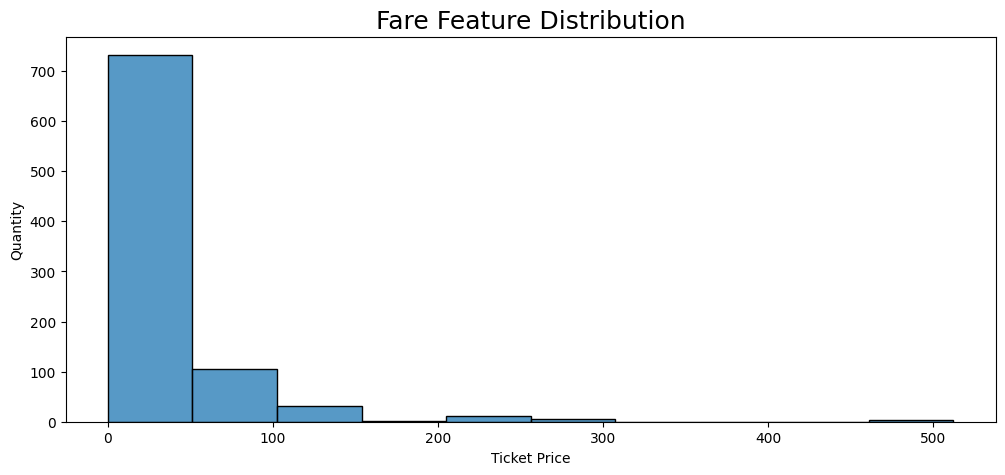

In [8]:
plt.figure(figsize = (12, 5))

plt.title("Fare Feature Distribution", fontsize = 18)

sns.histplot(train_df.loc[:,"Fare"], bins = 10)

plt.ylabel("Quantity")
plt.xlabel("Ticket Price")

plt.show()

In [9]:
train_df_embarked = train_df.loc[:, "Embarked"].value_counts().reset_index(name = "Quantity")
train_df_embarked["Embarked"] = train_df_embarked["Embarked"].replace(to_replace = {"S": "Southampton", "C": "Cherbourg", "Q": "Queenstown"})
train_df_embarked

,Embarked,Quantity
0,Southampton,644
1,Cherbourg,168
2,Queenstown,77


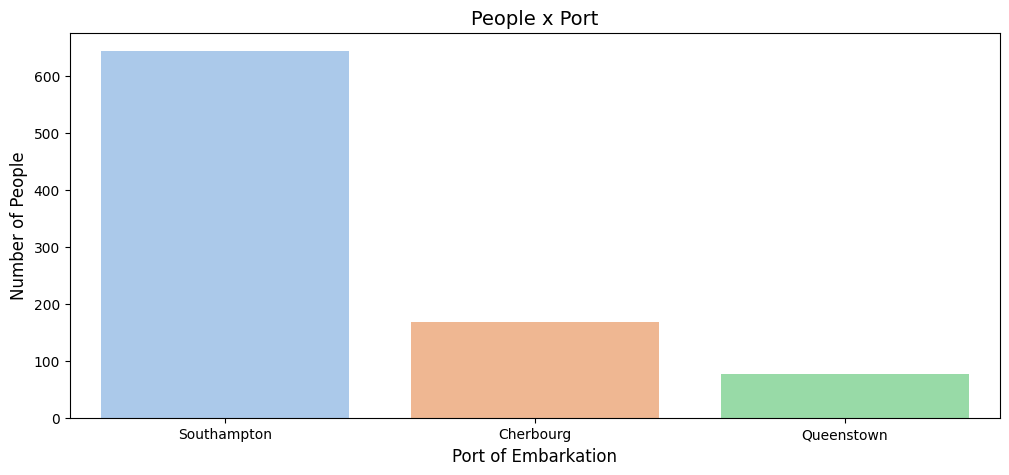

In [10]:
plt.figure(figsize = (12, 5))

plt.title("People x Port", fontsize = 14)

sns.barplot(x = train_df_embarked["Embarked"], y = train_df_embarked["Quantity"], palette = "pastel")

plt.xlabel("Port of Embarkation", fontsize = 12)
plt.ylabel("Number of People", fontsize = 12)

plt.show()

In [11]:
train_df_sex = train_df.loc[:, "Sex"].value_counts().reset_index(name = "Quantity")
train_df_sex

,Sex,Quantity
0,male,577
1,female,314


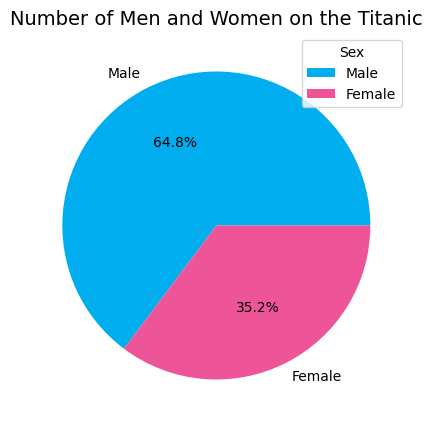

In [12]:
plt.figure(figsize = (12, 5))

plt.title("Number of Men and Women on the Titanic", fontsize = 14)
plt.pie(x = train_df_sex["Quantity"], autopct = '%1.1f%%', labels=train_df_sex['Sex'].str.capitalize(), colors = ['#00ADEE', '#EE5599'])

plt.legend(title = "Sex")

plt.show()

In [13]:
train_df_survived_per_sex = train_df.groupby("Sex")["Survived"].value_counts().reset_index(name = "Quantity")
train_df_survived_per_sex

,Sex,Survived,Quantity
0,female,1,233
1,female,0,81
2,male,0,468
3,male,1,109


In [14]:
female_survived_filter = train_df_survived_per_sex[train_df_survived_per_sex["Sex"] == "female"]
male_survived_filter = train_df_survived_per_sex[train_df_survived_per_sex["Sex"] == "male"]

In [15]:
male_survived_filter = male_survived_filter.replace(to_replace = {1: "Survived", 0: "Didn't Survive"})
male_survived_filter

,Sex,Survived,Quantity
2,male,Didn't Survive,468
3,male,Survived,109


In [16]:
female_survived_filter = female_survived_filter.replace(to_replace = {1: "Survived", 0: "Didn't Survive"})
female_survived_filter

,Sex,Survived,Quantity
0,female,Survived,233
1,female,Didn't Survive,81


In [17]:
colors = ['#DDADDD', '#ADD8E6']
male_colors_ordered = [colors[0] if label == "Didn't Survive" else colors[1] for label in male_survived_filter["Survived"]]
female_colors_ordered = [colors[0] if label == "Didn't Survive" else colors[1] for label in female_survived_filter["Survived"]]

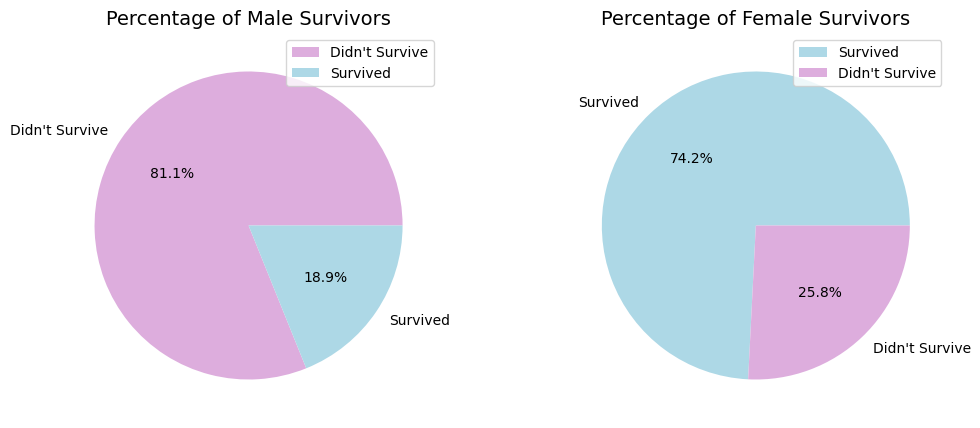

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

ax[0].set_title("Percentage of Male Survivors", fontsize = 14)
ax[0].pie(male_survived_filter["Quantity"], autopct = "%1.1f%%", labels = male_survived_filter["Survived"], colors = male_colors_ordered)
ax[0].legend()

ax[1].set_title("Percentage of Female Survivors", fontsize = 14)
ax[1].pie(female_survived_filter["Quantity"], autopct = "%1.1f%%", labels = female_survived_filter["Survived"], colors = female_colors_ordered)
ax[1].legend()

plt.show()

## :: Data Preparation

In [19]:
from sklearn.impute import SimpleImputer

In [20]:
train_df.sample(n = 5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
99,100,0,2,"Kantor, Mr. Sinai",male,34.0,1,0,244367,26.0,NaN,S
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0,NaN,S
178,179,0,2,"Hale, Mr. Reginald",male,30.0,0,0,250653,13.0,NaN,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,C23 C25 C27,S
600,601,1,2,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",female,24.0,2,1,243847,27.0,NaN,S


In [21]:
X_columns_cat = ["Pclass", "Sex", "Embarked"]
X_columns_num = ["Age", "SibSp", "Parch", "Fare"]

In [22]:
X_train_cat = train_df.loc[:, X_columns_cat].values
X_train_num = train_df.loc[:, X_columns_num].values
y_train = train_df["Survived"].values

In [23]:
X_test_cat = test_df.loc[:, X_columns_cat].values
X_test_num = test_df.loc[:, X_columns_num].values
y_test = train_df["Survived"].values

In [24]:
imp_cat = SimpleImputer(strategy = "most_frequent")
X_train_cat = imp_cat.fit_transform(X_train_cat)
X_test_cat = imp_cat.transform(X_test_cat)

In [25]:
imp_num = SimpleImputer()
X_train_num = imp_num.fit_transform(X_train_num)
X_test_num = imp_num.transform(X_test_num)